# Testing watershed halo finder

Here, we compare the results of our watershed-based halo finder, which works directly on a gridded density field, with the FoF halo finder used by nbodykit, which acts on a particle catalog.

In [2]:
import hickle as hkl
import postEoR.tools as tools
import numpy as np
import matplotlib.pyplot as plt
from hmf import MassFunction

We load in the particle distribution from nbodykit, which has been painted to a gridded density field for use in the watershed halo finder.
1000 particles per cell are used, each with a mass of $3.93295\times 10^8 M_{\odot}$ (to give the field an average density equal to the critical density of the universe).

In [2]:
dens = hkl.load("nbody_dens_1000_particles_per_cell.hkl")

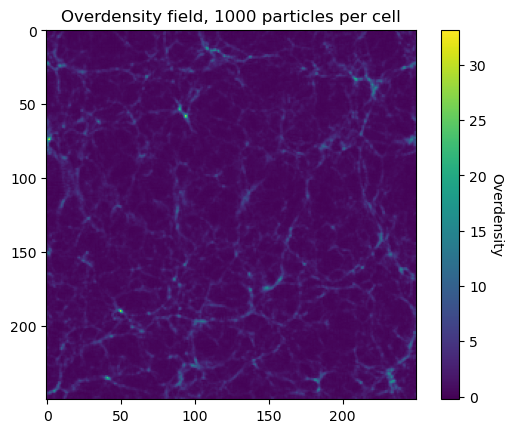

In [4]:
plt.imshow(dens[:, :, 10])
plt.title("Overdensity field, 1000 particles per cell")
cbar = plt.colorbar()
cbar.set_label("Overdensity", rotation=270, labelpad = 12)

In [2]:
halos = tools.find_halos_watershed(dens, box_len=50, HII_dim=250)
hkl.dump(halos, "watershed_halos_1000.hkl", mode="w")

250059


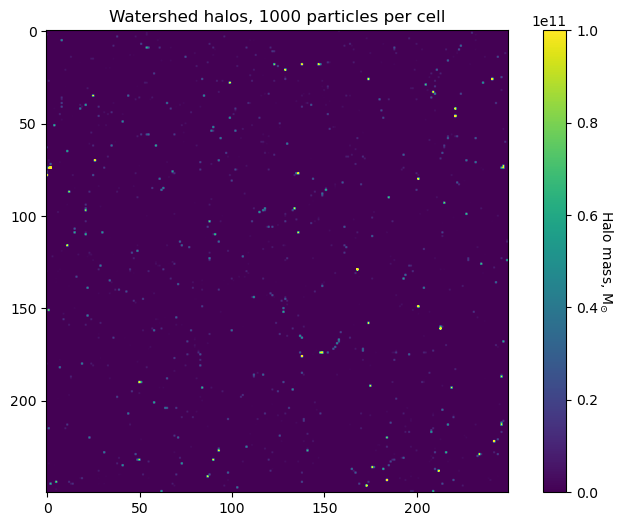

In [9]:
plt.imshow(halos[:, :, 10], vmax=1e11)
plt.title("Watershed halos, 1000 particles per cell")
cbar = plt.colorbar()
cbar.set_label("Halo mass, M$_{\odot}$", rotation=270, labelpad = 12)

For a visual comparison of equivalent halos that may not have centred on the same cell, we also plot below the watershed halos summed across a 5 Mpc distance.

Text(0.5, 1.0, 'Combined watershed halos across 5 Mpc')

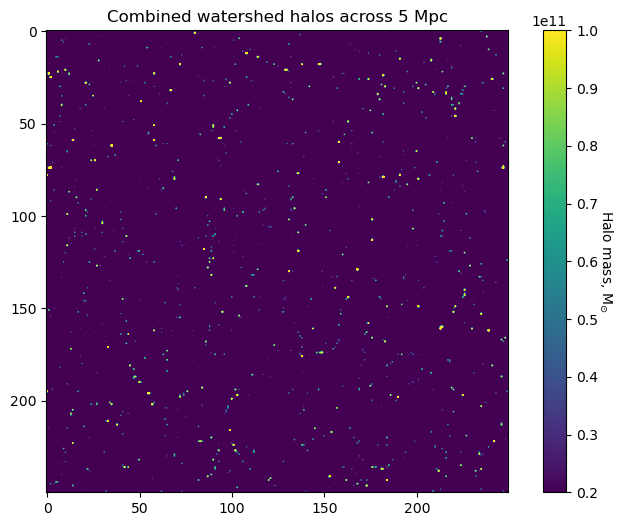

In [23]:
combined_halos = halos[:, :, 9] + halos[:, :, 10] + halos[:, :, 11] + halos[:, :, 12] + halos[:, :, 8]
plt.imshow(combined_halos,vmax=1e11, vmin=0.2e11)
cbar = plt.colorbar()
cbar.set_label("Halo mass, M$_{\odot}$", rotation=270, labelpad = 12)
plt.title("Combined watershed halos across 5 Mpc")


/Users/Rach/opt/anaconda3/envs/fast/lib/python3.11/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


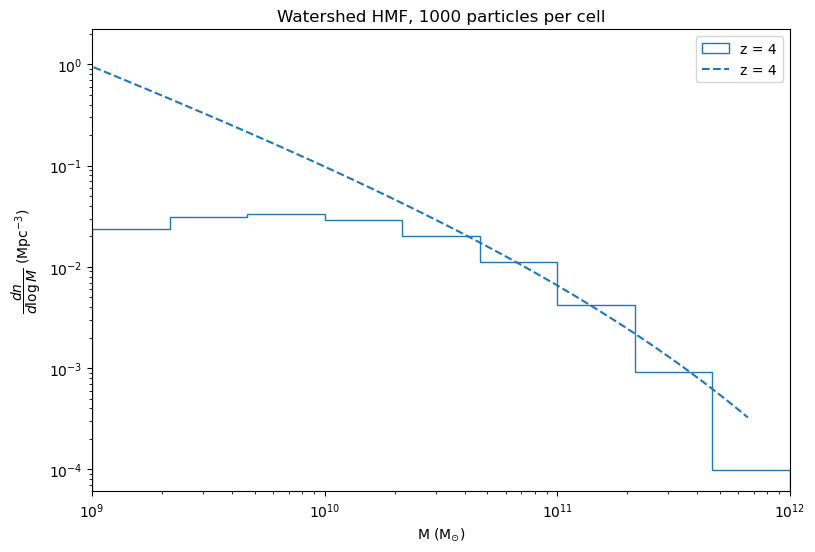

In [22]:
Mmin = 9
Mmax = 12
box_len=50
OMm = 0.30964144154550644
z = 4
color = "tab:blue"
linestyle = "--"
hlittle = 67.66 / 100

bins1 = np.geomspace(10**Mmin, 10**Mmax, 10)
counts, bins = np.histogram(halos, bins1)

los_dist = box_len

plt.rcParams['figure.figsize'] = [9, 6]
bins_plot = (bins[1:] + bins[:-1]) / 2
plt.hist(bins_plot, bins, weights=(2 * counts / (np.log(bins[1:]+bins[:-1])*box_len**2*los_dist)), histtype='step', label='z = ' + str(z), color=str(color))

mf1 = MassFunction(Mmin=Mmin, Mmax=Mmax, z = z,
            cosmo_params={"Om0":OMm}, 
            hmf_model="Watson") 

plt.plot(mf1.m * hlittle,mf1.dndm * mf1.m, label="z = " + str(z), linestyle=str(linestyle), color=str(color))
plt.title("Watershed HMF, 1000 particles per cell")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel('$\dfrac{dn}{d\log M}$ (Mpc$^{-3}$)')
plt.xlabel('M (M$_{\odot}$)')
plt.xlim(10**Mmin, 10**Mmax)

plt.show()

Now, we plot the nbodykit halos, which have been painted to a mesh for analysis here.
We remove any negative halo values that have arisen from any interlacing and set them to 0, and also convert the field from a halo overdensity to solar masses.

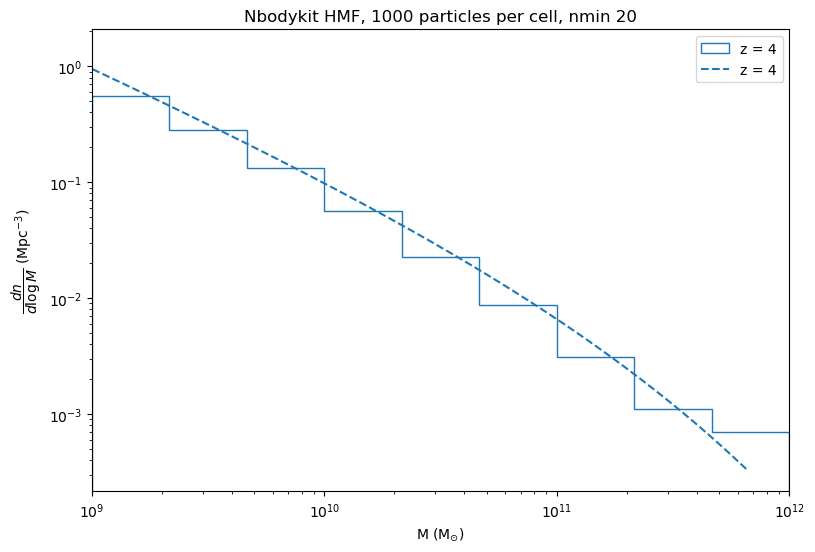

In [21]:
Mmin = 9
Mmax = 12
box_len=50
OMm = 0.30964144154550644
z = 4
color = "tab:blue"
linestyle = "--"
hlittle = 67.66 / 100
halo_field = hkl.load("nbody_halos_nmin20_1000.hkl")

halo_field[halo_field < 0] = 0
halo_field *= 3.93295e8

bins1 = np.geomspace(10**Mmin, 10**Mmax, 10)
counts, bins = np.histogram(halo_field, bins1)

los_dist = box_len

plt.rcParams['figure.figsize'] = [9, 6]
bins_plot = (bins[1:] + bins[:-1]) / 2
plt.hist(bins_plot, bins, weights=(2 * counts / (np.log(bins[1:]+bins[:-1])*box_len**2*los_dist)), histtype='step', label='z = ' + str(z), color=str(color))
mf1 = MassFunction(Mmin=Mmin, Mmax=Mmax, z = z,
            cosmo_params={"Om0":OMm}, 
            hmf_model="Watson") 

plt.plot(mf1.m * hlittle,mf1.dndm * mf1.m, label="z = " + str(z), linestyle=str(linestyle), color=str(color))
plt.title("Nbodykit HMF, 1000 particles per cell, nmin 20")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel('$\dfrac{dn}{d\log M}$ (Mpc$^{-3}$)')
plt.xlabel('M (M$_{\odot}$)')
plt.xlim(10**Mmin, 10**Mmax)

plt.show()

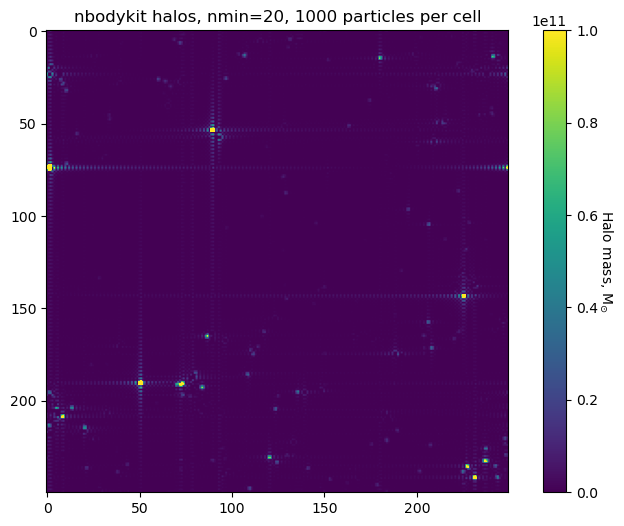

In [15]:
plt.imshow(halo_field[:, :, 10], vmax=1e11)
plt.title("nbodykit halos, nmin=20, 1000 particles per cell")
cbar = plt.colorbar()
cbar.set_label("Halo mass, M$_{\odot}$", rotation=270, labelpad = 12)

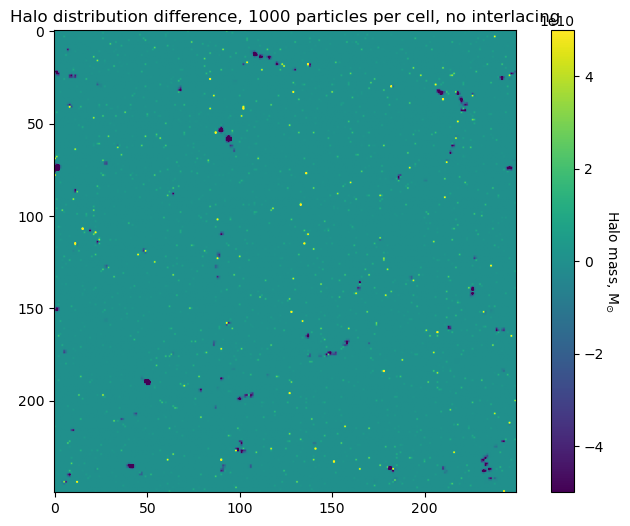

In [52]:
diff = halos - halo_field

plt.imshow(diff[:, :, 10], vmax=0.05e12, vmin=-0.05e12)
plt.title("Halo distribution difference, 1000 particles per cell, no interlacing")
cbar = plt.colorbar()
cbar.set_label("Halo mass, M$_{\odot}$", rotation=270, labelpad = 12)

Below, we briefly compare the overdensity distribution obtained with nbodykit when using 100 particles per cell vs using 1000.

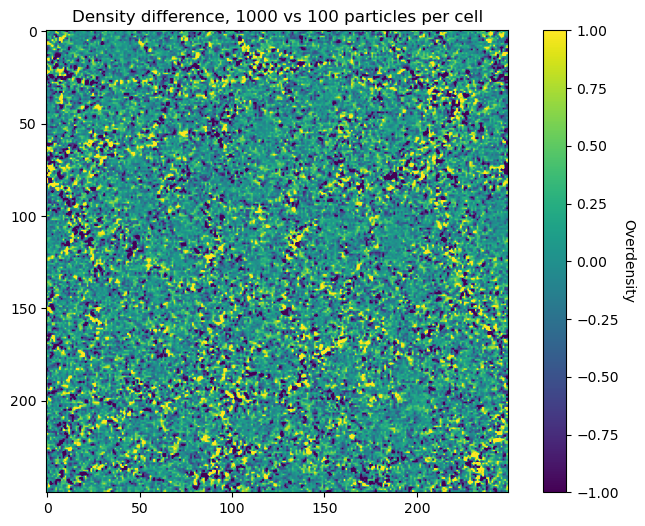

In [56]:
dens1000 = hkl.load("nbody_dens_1000_particles_per_cell.hkl")
dens100 = hkl.load("nbody_dens.hkl")

dens_diff = dens1000 - dens100

plt.imshow(dens_diff[:, :, 10], vmax=1, vmin=-1)
plt.title("Density difference, 1000 vs 100 particles per cell")
cbar = plt.colorbar()
cbar.set_label("Overdensity", rotation=270, labelpad = 12)

We plot the theoretical HMF, the HMF of the watershed halos, and the HMF of the nbodykit halos on the same plot for a direct comparison.

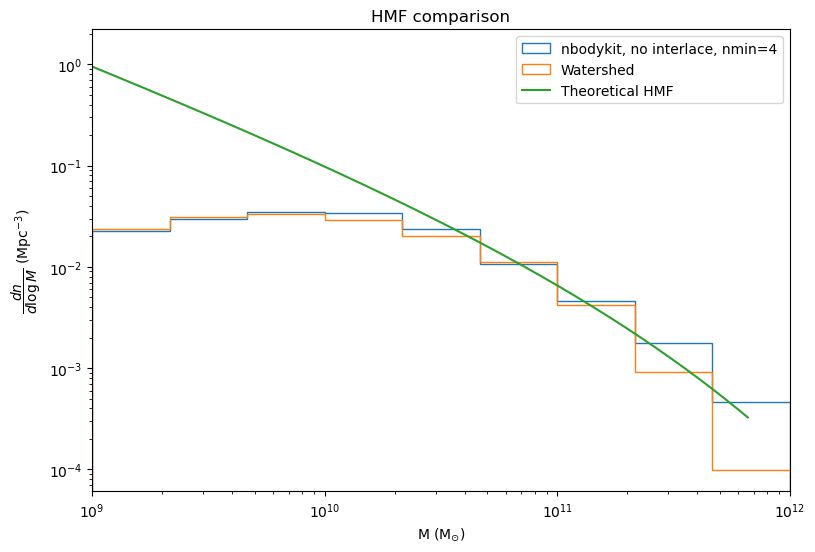

In [8]:
# mega plot

watershed_halos = hkl.load("watershed_halos_1000.hkl")
nbodykit_halos = hkl.load("nbody_halos_nmin4_1000_nointerlace.hkl")


Mmin = 9
Mmax = 12
box_len=50
OMm = 0.30964144154550644
z = 4
color = "tab:blue"
linestyle = "--"
hlittle = 67.66 / 100

nbodykit_halos[nbodykit_halos < 0] = 0
nbodykit_halos *= 3.93295e8

bins1 = np.geomspace(10**Mmin, 10**Mmax, 10)
counts, bins = np.histogram(nbodykit_halos, bins1)
los_dist = box_len
plt.rcParams['figure.figsize'] = [9, 6]
bins_plot = (bins[1:] + bins[:-1]) / 2
plt.hist(bins_plot, bins, weights=(2 * counts / (np.log(bins[1:]+bins[:-1])*box_len**2*los_dist)), histtype='step', label="nbodykit, no interlace, nmin=4", color="tab:blue")

bins1 = np.geomspace(10**Mmin, 10**Mmax, 10)
counts, bins = np.histogram(watershed_halos, bins1)
los_dist = box_len
plt.rcParams['figure.figsize'] = [9, 6]
bins_plot = (bins[1:] + bins[:-1]) / 2
plt.hist(bins_plot, bins, weights=(2 * counts / (np.log(bins[1:]+bins[:-1])*box_len**2*los_dist)), histtype='step', label="Watershed", color="tab:orange")


mf1 = MassFunction(Mmin=Mmin, Mmax=Mmax, z = z,
            cosmo_params={"Om0":OMm}, 
            hmf_model="Watson") 

plt.plot(mf1.m * hlittle,mf1.dndm * mf1.m, label="Theoretical HMF", color="tab:green")
plt.title("HMF comparison")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel('$\dfrac{dn}{d\log M}$ (Mpc$^{-3}$)')
plt.xlabel('M (M$_{\odot}$)')
plt.xlim(10**Mmin, 10**Mmax)

plt.show()

# Using nbodykit halo catalog directly

In addition to calculating the HMF from the meshed nbodykit halos, we also plot below the HMF using the halos directly from the catalog generated by the FoF halo finder in nbodykit.

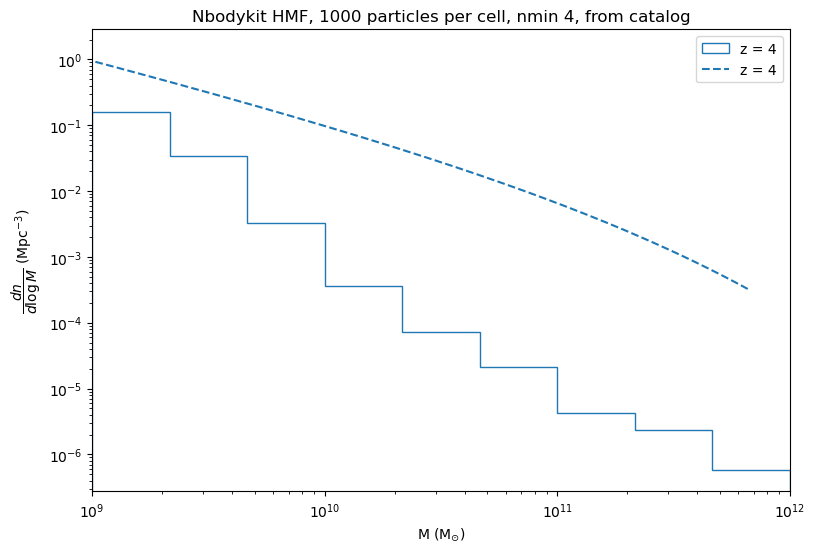

In [24]:
Mmin = 9
Mmax = 12
box_len=50
OMm = 0.30964144154550644
z = 4
color = "tab:blue"
linestyle = "--"
hlittle = 67.66 / 100

counts, bins = hkl.load("catalog_hist.hkl")

los_dist = box_len

plt.rcParams['figure.figsize'] = [9, 6]
bins_plot = (bins[1:] + bins[:-1]) / 2
plt.hist(bins_plot, bins, weights=(2 * counts / (np.log(bins[1:]+bins[:-1])*box_len**2*los_dist)), histtype='step', label='z = ' + str(z), color=str(color))
mf1 = MassFunction(Mmin=Mmin, Mmax=Mmax, z = z,
            cosmo_params={"Om0":OMm}, 
            hmf_model="Watson") 

plt.plot(mf1.m * hlittle,mf1.dndm * mf1.m, label="z = " + str(z), linestyle=str(linestyle), color=str(color))
plt.title("Nbodykit HMF, 1000 particles per cell, nmin 4, from catalog")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel('$\dfrac{dn}{d\log M}$ (Mpc$^{-3}$)')
plt.xlabel('M (M$_{\odot}$)')
plt.xlim(10**Mmin, 10**Mmax)

plt.show()